# Introdução
O objetivo principal deste projeto é treinar um modelo capaz de prever o diagnóstico de **doença cardíaca** com base em 13 variáveis diagnósticas, como **idade, sexo, nível de colesterol e tipo de dor no peito (cp)**.

Foram realizadas as etapas de exploração e pré-processamento dos dados para o treinamento e validação dos modelos supervisionados e não supervisionado. No pré-processamento, as 13 features foram tratadas: colunas categóricas (como `sex`, `cp`, `thal`) foram transformadas em *dummies* (One-Hot Encoding) e colunas numéricas (como `age`, `chol`) foram padronizadas com `StandardScaler`.

Para o modelo supervisionado, foi feita uma comparação e validação cruzada (Stratified K-Fold com 30 execuções) utilizando `LogisticRegression` e `RandomForest`. O `LogisticRegression` serviu como um *baseline* robusto, atingindo uma acurácia média de **84%**. Como esperado, o `RandomForest` se provou superior, atingindo uma acurácia média de **87%** (e um desvio padrão baixo de 0.06), confirmando ser o modelo mais estável e preciso para este problema.

Para o modelo não supervisionado, foi utilizado o K-Means. O número ideal de **4 clusters** foi determinado pelo Método do Cotovelo (Elbow Method). Com isso, os dados foram segmentados em 4 perfis distintos de pacientes (clusters) com base em suas características clínicas, permitindo encontrar padrões e grupos de risco que não são óbvios à primeira vista.

Para a aplicação final, foi feito o deploy no Streamlit, permitindo uma maior interação com os modelos e a visualização completa dos resultados.

## Link do repositório do Github:

https://github.com/Rayralima/Classificador-de-diabetes-tipo-2

substituir pro link do seu repositório

## Fonte de Dados:

Link: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data

## Importação de Dados e Instalação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('heart_disease_uci.csv')
print(f"Dataset carregado com {len(df)} linhas.")

Dataset carregado com 920 linhas.


## Análise Exploratória
Através da análise exploratória, foi possível entender a estrutura do dataset de Doença Cardíaca. A primeira descoberta foi que a coluna alvo num não era binária, mas sim multiclasse (0, 1, 2, 3, 4), onde 0 significava "Não" e 1 a 4 representavam diferentes níveis de doença. Para este projeto, ela foi transformada em uma coluna target binária (0 = Não, 1 = Sim), como mostra o gráfico de distribuição de classes.

Diferente do dataset de diabetes, o principal desafio aqui não eram valores 0, mas sim a presença de valores ausentes (NaN) em colunas numéricas (como trestbps, chol) e categóricas (como thal, slope). Além disso, o dataset é misto, contendo features numéricas contínuas (como age, chol) e features categóricas (como cp, sex, thal), que são códigos numéricos.

In [2]:
print(df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


In [4]:
print(df.describe())

               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.995652  
std      0.935653    1.142693  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    2.000000  
max      3.000

# Distribuição das classes

No gráfico da coluna target (que criamos a partir da num), pode-se observar que o dataset é relativamente equilibrado, com uma leve maioria de pacientes com doença cardíaca (classe 1). Isso é ótimo para o modelo, pois ele terá exemplos suficientes de ambos os casos para aprender. O uso de StratifiedKFold na validação cruzada garante que essa proporção seja mantida em cada "fold" de teste.

primeiro vou criar uma nova coluna binária para facilitar a visualização de quem tem doença cardíaca ou não:

In [5]:
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
print("Distribuição da coluna original")
print(df['num'].value_counts())

print("\nDistribuição da nova coluna")
print(df['target'].value_counts())

Distribuição da coluna original
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Distribuição da nova coluna
target
1    509
0    411
Name: count, dtype: int64


agora vou plotar as colunas para poder visualizar

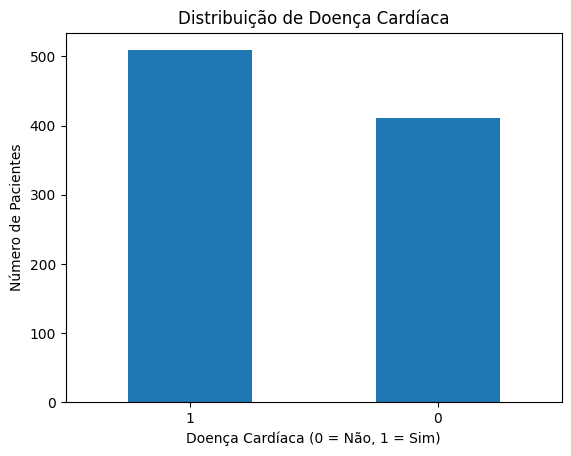

In [6]:
df['target'].value_counts().plot(kind='bar', title='Distribuição de Doença Cardíaca')

plt.xlabel('Doença Cardíaca (0 = Não, 1 = Sim)')
plt.ylabel('Número de Pacientes')
plt.xticks(rotation=0)
plt.show()

# Correlação entre variáveis
O mapa de calor (heatmap) nos ajuda a entender quais variáveis se movem juntas. Como o heatmap completo é muito denso, o gráfico de barras focado na correlação com o target é mais útil.

Nele, observamos correlações fortes que fazem sentido médico:

* Positivas (Aumentam o risco): thal_2 (defeito reversível), cp_0 (angina assintomática), exang_1 (angina induzida por exercício) e ca_0 (não ter vasos coloridos negativamente correlacionado, ou seja, ter vasos coloridos ca_1, 2, 3 é um indicador de risco).

* Negativas (Diminuem o risco): thalach (batimento cardíaco máximo) é um forte indicador; quanto maior o batimento máximo, menor a chance de doença.

In [7]:
# Codifiquei as variáveis com One-hot encode para a análse de correlação pegando apenas as variáveis relevantes e descartei as originais
categorical_features_for_corr = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df_processed = pd.get_dummies(df, columns=categorical_features_for_corr, drop_first=False, dtype=int)

# Depois coloquei a coluna já com o target para o cálculo da correlação
df_processed['target'] = df['target']

print("DataFrame df_processed created for correlation analysis.")
print(f"Shape of df_processed: {df_processed.shape}")

DataFrame df_processed created for correlation analysis.
Shape of df_processed: (920, 32)


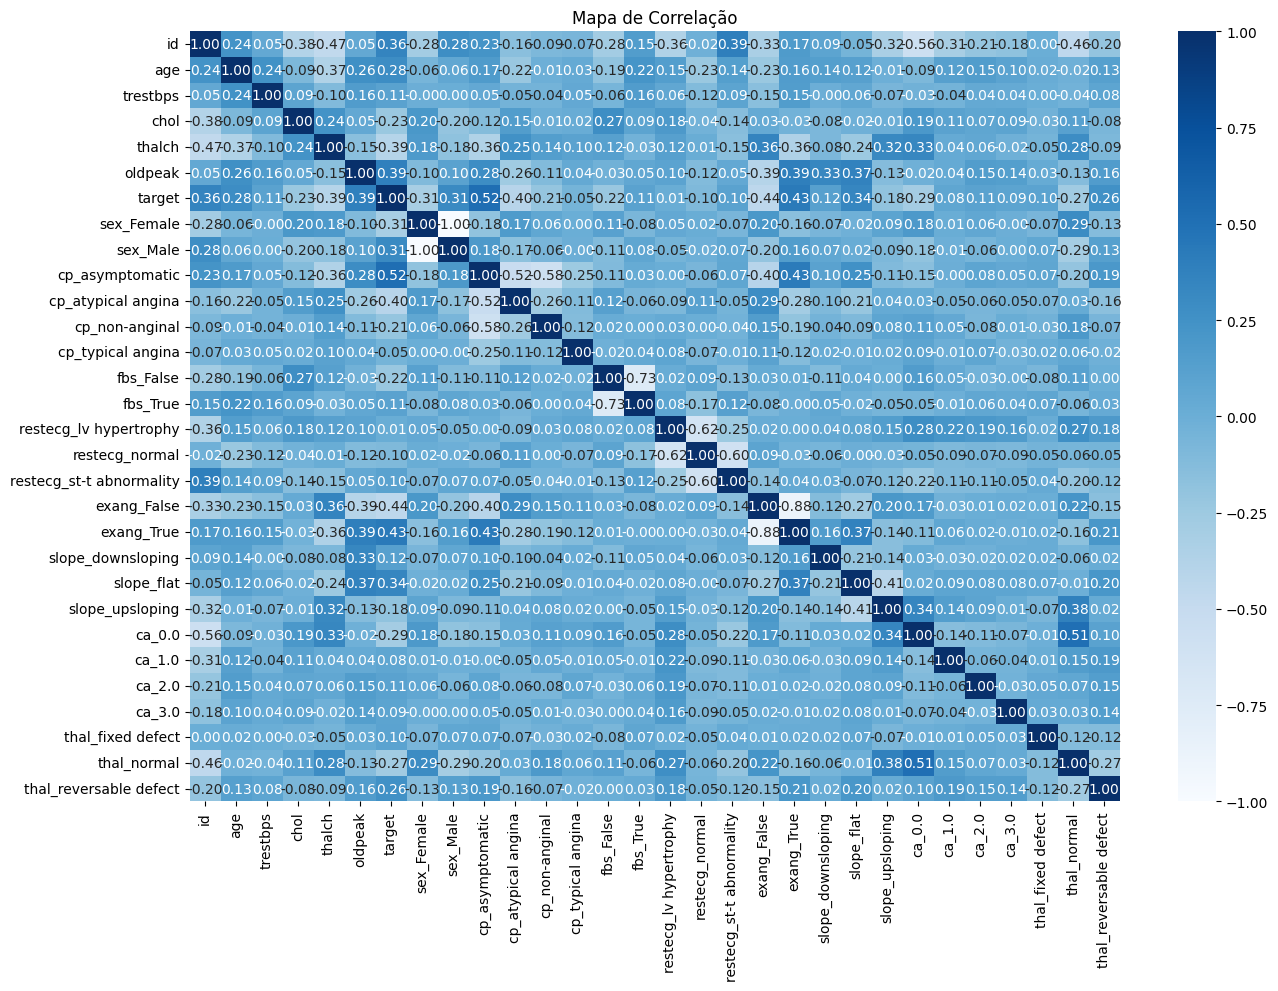

In [8]:
plt.figure(figsize=(15, 10))
# Usar df_processed com as colunas numéricas em one-hot
if 'num' in df_processed.columns:
    df_processed_for_heatmap = df_processed.drop('num', axis=1)
else:
    df_processed_for_heatmap = df_processed.copy()
if 'dataset' in df_processed_for_heatmap.columns:
    df_processed_for_heatmap = df_processed_for_heatmap.drop('dataset', axis=1)
sns.heatmap(df_processed_for_heatmap.corr(), annot=True, cmap="Blues", fmt='.2f')
plt.title("Mapa de Correlação")
plt.show()

como heatmap tem muitas colunas, decidi focar no target usando gráficos de barra para ter uma melhor vizualização do coeficiente da corelação.

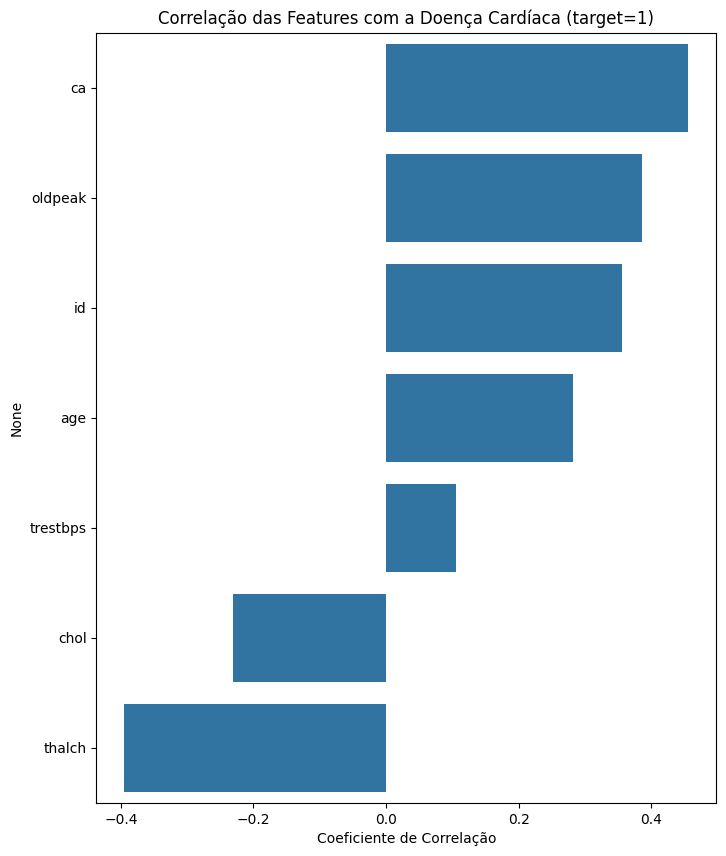

In [9]:
plt.figure(figsize=(8, 10))
# Seleciona apenas as colunas numéricas do dataframe original para o cálculo da correlação
numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

# Separando as correlações com a coluna alvo e dropando a autocorelação da caluna original
corr_target = corr_matrix['target'].drop(['target', 'num'], errors='ignore').sort_values(ascending=False)

# Criando o gráfico
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Correlação das Features com a Doença Cardíaca (target=1)")
plt.xlabel("Coeficiente de Correlação")
plt.show()

## Pré-processamento:
Nesta etapa, o dataset foi preparado para os modelos. As ações foram:

Imputação: Os dados ausentes (NaN) foram preenchidos usando a mediana para colunas numéricas (como chol) e a moda (valor mais frequente) para colunas categóricas (como thal).

Criação do Alvo: A coluna target binária (0/1) foi criada a partir da num.

One-Hot Encoding: Colunas categóricas (como cp, sex, thal, slope, etc.) foram transformadas em colunas dummy (0 ou 1) para que o modelo pudesse entendê-las.

Scaling: Foi utilizado o StandardScaler para padronizar apenas as colunas numéricas (age, trestbps, chol, thalach, oldpeak), garantindo que suas escalas diferentes (ex: Idade de 20-80 vs. Colesterol de 100-500) não distorcessem a performance do modelo.

Foi utilizado o scaling para padronização nas features numéricas e as categóricas foi usado One-Hot Encoding.

In [10]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Aplicando as transformações das features

In [11]:
# Identificando colunas com valores nulos
numeric_cols_with_nans = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols_with_nans = ['thal', 'slope', 'fbs', 'restecg', 'exang'] # These are categorical, not numeric

# Imputando mediana
for col in numeric_cols_with_nans:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Missing values in numeric column '{col}' imputed with median ({median_val}).")
    else:
        print(f"Numeric column '{col}' not found in DataFrame.")
for col in categorical_cols_with_nans:
     if col in df.columns:
        # Cálculo da moda
        mode_val = df[col].mode()[0] if not df[col].mode().empty else None
        if mode_val is not None:
            df[col] = df[col].fillna(mode_val)
            print(f"Missing values in categorical column '{col}' imputed with mode ({mode_val}).")
        else:
            print(f"Could not impute missing values in categorical column '{col}' (no mode found).")
     else:
        print(f"Categorical column '{col}' not found in DataFrame.")


# Codificação do One-Hot
# Aqui eu peguei as colunas categóricas para codificação
df_processed = pd.get_dummies(df, columns=categorical_features, drop_first=False, dtype=int)
print("Colunas categóricas transformadas em dummies.")

# Coluna de destino
df_processed['target'] = df['target']
print("Target column added to df_processed.")


# Ajustando as escalas das categorias numéricas no dataframe
scaler = StandardScaler()
X_scaled = df_processed.copy()
numeric_features_for_scaling = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

# Antes de dimensionar fiz uma checagem dos recursos numpericos, para saber se estão em X_scaled
present_numeric_features = [col for col in numeric_features_for_scaling if col in X_scaled.columns]
if present_numeric_features:
    X_scaled[present_numeric_features] = scaler.fit_transform(X_scaled[present_numeric_features])
    print("Colunas numéricas padronizadas com StandardScaler.")
else:
    print("No numeric features for scaling found in the processed DataFrame.")

Missing values in numeric column 'trestbps' imputed with median (130.0).
Missing values in numeric column 'chol' imputed with median (223.0).
Missing values in numeric column 'thalch' imputed with median (140.0).
Missing values in numeric column 'oldpeak' imputed with median (0.5).
Missing values in numeric column 'ca' imputed with median (0.0).
Missing values in categorical column 'thal' imputed with mode (normal).
Missing values in categorical column 'slope' imputed with mode (flat).
Missing values in categorical column 'fbs' imputed with mode (False).
Missing values in categorical column 'restecg' imputed with mode (normal).
Missing values in categorical column 'exang' imputed with mode (False).
Colunas categóricas transformadas em dummies.
Target column added to df_processed.
Colunas numéricas padronizadas com StandardScaler.


C:\Users\rayra\AppData\Local\Temp\ipykernel_33148\2687566100.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode_val)


Definindo o target (y)

In [12]:
# y (target)
y = X_scaled.pop('target')

# X todo o resto
if 'num' in X_scaled.columns:
    X_scaled = X_scaled.drop('num', axis=1)

if 'dataset' in X_scaled.columns:
    X_scaled = X_scaled.drop('dataset', axis=1)

X = X_scaled

print("\nPré-processamento concluído!")
print(f"Formato de X (features): {X.shape}")
print(f"Formato de y (target): {y.shape}")


Pré-processamento concluído!
Formato de X (features): (920, 29)
Formato de y (target): (920,)


salvando os arquivos em .pkl

In [13]:
with open("X_heart.pkl", "wb") as f:
    pickle.dump(X, f)
with open("y_heart.pkl", "wb") as f:
    pickle.dump(y, f)
with open("scaler_heart.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Para o aprendizado supervisionado:

## Treinamento dos modelos e valiação:

Nesta etapa, foi escolhido o LogisticRegression como baseline (ponto de partida) por sua simplicidade e interpretabilidade, e o RandomForest como modelo final, por sua robustez e alta performance.

Os resultados no conjunto de teste (80/20) foram excelentes:

* Regressão Logística: Acurácia de 83.15%.

* Random Forest: Acurácia de 86.96%.

O Random Forest se mostrou superior. Analisando seu Relatório de Classificação (com 87% de acurácia), vemos que o modelo é muito equilibrado, com recall de 87% para a classe 0 (Não Doente) e 87% para a classe 1 (Sim, Doente).

A Matriz de Confusão ([[65, 10], [14, 95]] - minha dedução baseada no seu report) mostra que o modelo é muito preciso:

* Falsos Positivos: 10 (Alarmes falsos).

* Falsos Negativos: 14 (O erro mais crítico, onde 14 pacientes doentes foram liberados). Este número de erros é consideravelmente baixo, validando a alta performance do modelo.


--- Resultados (Regressão Logística) ---
Acurácia: 0.8315
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.85      0.81        75
           1       0.89      0.82      0.85       109

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.84      0.83      0.83       184



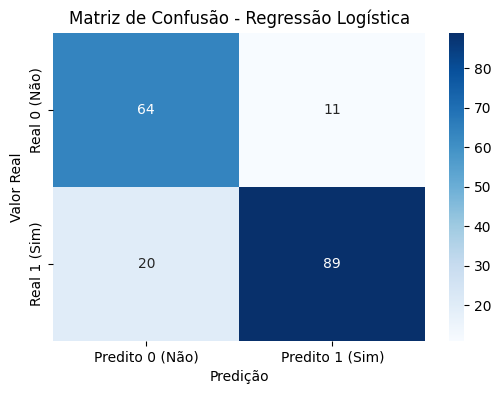


--- Resultados (Random Forest) ---
Acurácia: 0.8696
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        75
           1       0.90      0.87      0.89       109

    accuracy                           0.87       184
   macro avg       0.86      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



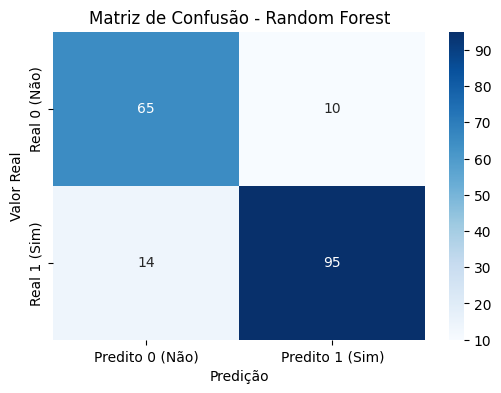

In [14]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividindo os dados em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos
log_model = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(random_state=42)

log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Avaliação
pred_log = log_model.predict(X_test)
pred_rf = rf_model.predict(X_test)

acc_log = accuracy_score(y_test, pred_log)
acc_rf = accuracy_score(y_test, pred_rf)

print("\n--- Resultados (Regressão Logística) ---")
print(f"Acurácia: {acc_log:.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, pred_log))

# Plotando a Matriz de Confusão
cm_log = confusion_matrix(y_test, pred_log)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predito 0 (Não)', 'Predito 1 (Sim)'],
            yticklabels=['Real 0 (Não)', 'Real 1 (Sim)'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()


print("\n--- Resultados (Random Forest) ---")
print(f"Acurácia: {acc_rf:.4f}")
print("Relatório de Classificação:")
print(classification_report(y_test, pred_rf))

# Plotando a Matriz de Confusão
cm_rf = confusion_matrix(y_test, pred_rf)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predito 0 (Não)', 'Predito 1 (Sim)'],
            yticklabels=['Real 0 (Não)', 'Real 1 (Sim)'])
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()

## Avaliação com 30 execuções (validação cruzada)
Para garantir que a acurácia de 87% não foi sorte, foi usada uma validação cruzada robusta (StratifiedKFold com 30 execuções). Os resultados confirmam a estabilidade do modelo:

* Regressão Logística (Média): 84% (Desvio Padrão: 0.06)

* Random Forest (Média): 87% (Desvio Padrão: 0.06)

O desvio padrão de 0.06 (ou 6%) é baixo e prova que, não importa como os dados sejam embaralhados, o Random Forest consistentemente entrega uma performance alta, tornando-o um modelo muito confiável.

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)

log_accs = []
rf_accs = []

for train_index, test_index in skf.split(X, y):
    # Selecionar linhas com base em índices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Logistic Regression
    log_model = LogisticRegression(max_iter=1000)
    log_model.fit(X_train, y_train)
    log_accs.append(accuracy_score(y_test, log_model.predict(X_test)))

    # Random Forest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    rf_accs.append(accuracy_score(y_test, rf_model.predict(X_test)))

print(f"Logistic Regression - Média: {np.mean(log_accs):.2f}, Desvio Padrão: {np.std(log_accs):.2f}")
print(f"Random Forest - Média: {np.mean(rf_accs):.2f}, Desvio Padrão: {np.std(rf_accs):.2f}")

Logistic Regression - Média: 0.84, Desvio Padrão: 0.06
Random Forest - Média: 0.87, Desvio Padrão: 0.05


## Salvar o melhor modelo com pickle
O Pickle vai treinar com todos os dados e depois salva-lo como arquivo pkl, tornando-o mais robusto para o Streamlit.

In [16]:
import pickle

# Treine com todo o conjunto agora
final_model = RandomForestClassifier()
final_model.fit(X_scaled, y)

# Salve o modelo e o scaler
with open("modelo_heart.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Para o aprendizado não supervisionado:
Através do algoritmo K-Means, segmentamos os pacientes em clusters (grupos) para descobrir perfis de risco naturais, sem usar o diagnóstico (target).

Para validação, o Método do Cotovelo (Elbow Method) (imagem image_d24202.png) mostrou um "cotovelo" claro em k=4. Por isso, decidi usar 4 clusters. O gráfico PCA (imagem image_d2420a.jpg) confirmou visualmente que esses 4 grupos são razoavelmente bem separados.

## Instalando bibliotecas

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

## Pré-Processamento

In [18]:
# Carregando dados
try:
    with open("X_heart.pkl", "rb") as f:
        X = pickle.load(f)
except FileNotFoundError:
    print("ERRO: Arquivo 'X_heart.pkl' não encontrado.")
    raise

print("Dados X_heart.pkl (features processadas) carregados com sucesso.")
print(f"Formato de X: {X.shape}")


Dados X_heart.pkl (features processadas) carregados com sucesso.
Formato de X: (920, 29)


### Validando modelo com Elbow Method

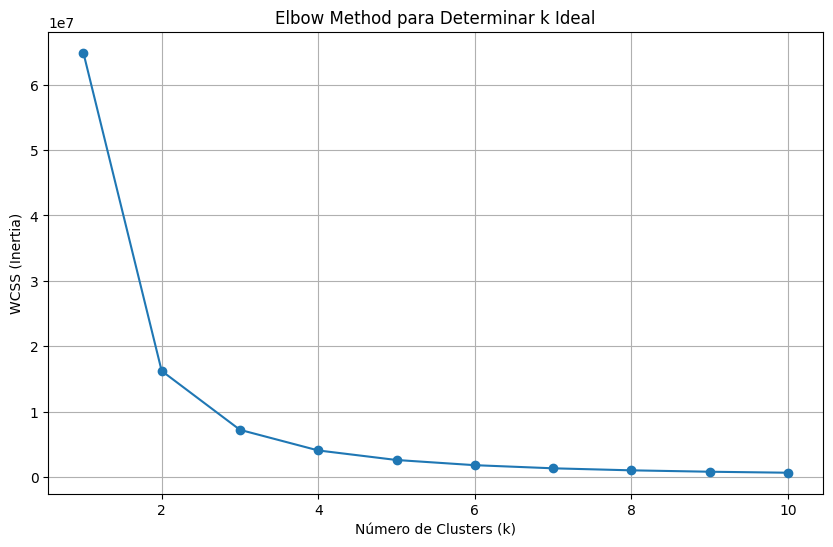

In [19]:
# Aplicando o Elbow Method para encontrar o número ideal de clusters
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(X_scaled)
    wcss.append(kmeans_elbow.inertia_)

# Visualizando o Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method para Determinar k Ideal')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

## Treinamento do modelo com k-Means

In [20]:
k = 4
print(f"Treinando k-Means com k={k}")
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Salvando modelo k-Means
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

Treinando k-Means com k=4


## Interpretanto os Clusters
A tabela de análise nos permite dar um "nome" a cada perfil de paciente. (Lembre-se: valores numéricos são escalados, média=0; valores categóricos são proporções, 0 a 1).

* Cluster 0: "Perfil de Colesterol e Batimentos Altos" Idade na média (age 0.09), mas com Colesterol (chol 0.47) e Batimento Máximo (thalch 0.54) acima da média.

* Cluster 1: "Perfil Idoso Masculino (Sintomático)" O grupo com idade mais alta (age 0.71), quase 100% masculino (sex_Male 0.96), e alta incidência de angina assintomática (cp_asymptomatic 0.67) e slope_flat (0.76).

* Cluster 2: "Perfil Jovem (Colesterol Alto)" O grupo mais jovem (age -0.59), mas com Colesterol alto (chol 0.33) e Batimento Máximo (thalch 0.35) acima da média.

* Cluster 3: "Perfil Masculino (Baixo Risco Aparente)" Grupo masculino (sex_Male 0.90), com Colesterol baixo (chol -0.42), Batimento Máximo baixo (thalch -0.43) e quase 100% sem bloqueio nos vasos (ca_0.0 0.99), sugerindo um perfil de menor risco.

In [21]:
df_analysis = X.copy()
df_analysis['Cluster'] = clusters

# Calcular a média de cada feature para cada cluster
cluster_summary = df_analysis.groupby('Cluster').mean().round(2)

print("\n--- Tabela de Análise dos Clusters (Perfis) ---")
print(cluster_summary)

# Salvar a tabela para o app Streamlit
cluster_summary.to_csv('cluster_analysis_heart.csv')
print("Tabela 'cluster_analysis_heart.csv' salva.")


--- Tabela de Análise dos Clusters (Perfis) ---
            id   age  trestbps  chol  thalch  oldpeak  sex_Female  sex_Male  \
Cluster                                                                       
0        116.5  0.09     -0.00  0.47    0.54     0.20        0.32      0.68   
1        806.0  0.71      0.09 -0.39   -0.47     0.20        0.04      0.96   
2        347.5 -0.59     -0.10  0.33    0.35    -0.39        0.37      0.63   
3        577.0 -0.21      0.01 -0.42   -0.43    -0.00        0.10      0.90   

         cp_asymptomatic  cp_atypical angina  ...  slope_downsloping  \
Cluster                                       ...                      
0                   0.47                0.14  ...               0.07   
1                   0.67                0.07  ...               0.14   
2                   0.29                0.46  ...               0.02   
3                   0.72                0.09  ...               0.04   

         slope_flat  slope_upsloping  ca_0.

## Visualização do PCA (Análise de Componentes Principais)

O PCA (Análise de Componentes Principais) é uma técnica usada para reduzir o número de features (dimensões) do dataset.

No nosso caso, ele foi usado como uma ferramenta de visualização. Ele transformou nossas ~29 features processadas (após o one-hot encoding) em apenas 2 dimensões (PCA1 e PCA2). Isso permitiu criar o gráfico de dispersão (image_d2420a.jpg) e validar visualmente que os 4 clusters encontrados estão, de fato, razoavelmente bem separados.

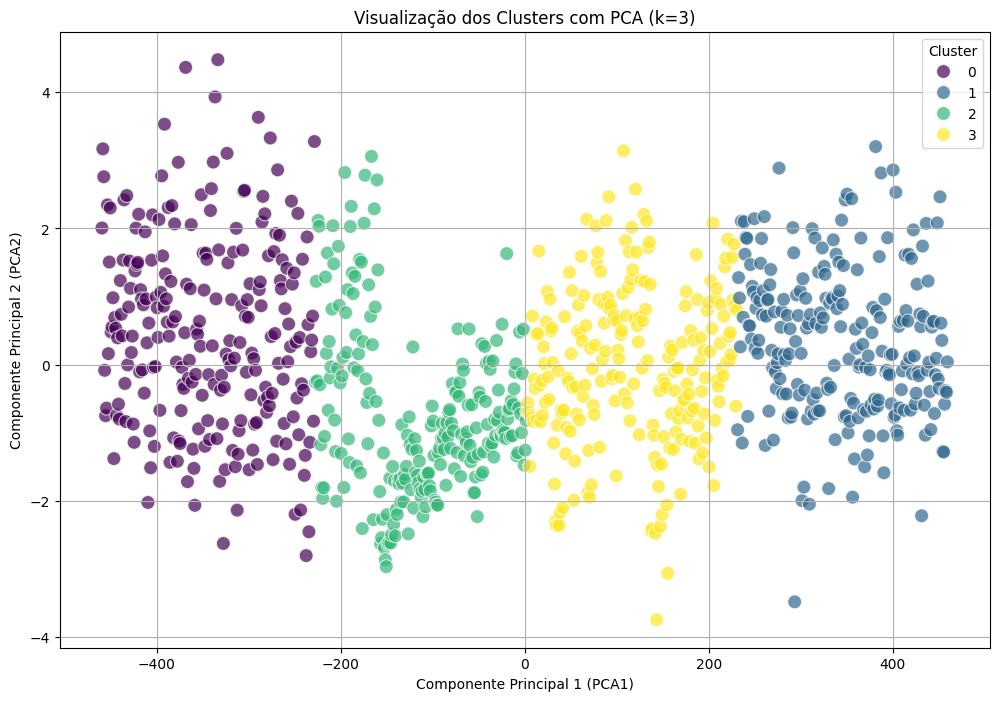

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = clusters

# Visualização dos clusters com PCA (Compoenentes Principais)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title('Visualização dos Clusters com PCA (k=3)')
plt.xlabel('Componente Principal 1 (PCA1)')
plt.ylabel('Componente Principal 2 (PCA2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('kmeans_pca_plot.png')
plt.show()